In [1]:
import numpy as np
import rpy2.robjects as robjects
# Rのインスタンスを取得
r = robjects.r
from rpy2.robjects import pandas2ri
pandas2ri.activate()
# Rのライブラリをロード
r = robjects.r
r('library(pdfCluster)')


R[write to console]: pdfCluster 1.0-4



In [2]:
import numpy as np
import tifffile
import os
import pickle
import joblib
import pandas as pd
from matplotlib import pyplot as plt
import concurrent.futures
import gc
import json

dt_local = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('structureness', 'f4'), ('blobness', 'f4'), ('intensity', 'f4'),
    ('size', 'u2'), ('padding', 'u2'), ('intensity2', 'f4'), ('intensity3', 'f4')
])


dt_annotated = np.dtype([
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'),('is_positive2','f4'),('is_positive3','f4')
])



dt_annotated_init = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'),('intensity','f4'),('structureness','f4'), # ここのis_positiveはinitial classifyによるもの
    ('intensity_2','f4'), ('intensity_3','f4')
])

dt_annotated_classified_intensity = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'), ('intensity','f4'),('structureness','f4'),
    ('intensity2','f4'),('intensity3','f4'), # ここのis_positiveはinitial classifyによるものにする
    ('norm_intensity_2','f4'), ('norm_intensity_3','f4')
])

# 必要なdtypeの定義
dt_needed = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('intensity','f4'),('structureness','f4')
])

dt_classified = np.dtype([
    ('is_positive','bool'), ('is_positive2','bool'),('is_positive3','bool')
])

dt_classified2 = np.dtype([
   ('is_positive','bool'), ('intensity','f4'),('intensity_2','f4'), ('intensity_3','f4')
])

def load_points(stack_dir, file_name):
    with open(os.path.join(stack_dir, file_name), "rb") as f:
        tmp = joblib.load(f)
        #print(f"File: {file_name}, tmp shape: {tmp.shape}, tmp dtype: {tmp.dtype}")  # tmpのshapeとdtypeを表示
        
        # ここでtmpは1次元の構造化配列で、各要素はdtypeにリストされたフィールドを持っています。
        # フィールド名をキーとしてデータにアクセスできます。
        new_array = np.zeros(tmp.shape, dtype=dt_needed)
        new_array['mapped_x'] = tmp['mapped_x']
        new_array['mapped_y'] = tmp['mapped_y']
        new_array['mapped_z'] = tmp['mapped_z']
        new_array['intensity'] = tmp['intensity']
        new_array['structureness'] = tmp['structureness']
        
        del tmp
        gc.collect()
        return new_array
    
def load_points_classified(stack_dir, file_name):
    with open(os.path.join(stack_dir, file_name), "rb") as f:
        #print(f)
        tmp = joblib.load(f)
        #print(tmp)
        # Determine the dtype based on the length of the first element of tmp
        if len(tmp[0]) == 3:
            dtype = dt_classified
        elif len(tmp[0]) == 4:
            dtype = dt_classified2
        else:
            raise ValueError("Unexpected length of elements in tmp.")
        point = np.zeros(tmp.shape, dtype=dtype)
        point[:] = tmp[:]
        #print(point)
        # numpy配列の各要素をPythonリストに変換
        
        list_array = point.tolist()
        # Pythonリストの各要素をnumpy配列に変換
        new_array = np.array([np.array(sublist) for sublist in list_array])
        del tmp,point,list_array
        gc.collect()
        return  new_array
    
def process_file (fw_dir_nu_, file_name):
    if file_name.endswith(".pkl"):
        #print(file_name)
        tmp_points_nu = load_points(fw_dir_nu_, file_name)
        try:
            tmp_points_classified = load_points_classified(fw_dir_nu_.replace('nu_R_/result', 'classified_'), file_name)    
            
            if tmp_points_classified.size > 0:
                tmp_points_nu = tmp_points_nu[tmp_points_classified.T[0]>0]
                #print(tmp_points_nu)
                del tmp_points_classified
                gc.collect()
                return tmp_points_nu
            else:
                return np.empty((10, 0))
            
        except Exception as e:
                return np.empty((10, 0))

# HDoGやnu Rをやりなおすまえにintensitiesしていることがあるので、これではダメ。
#def process_file_all (fw_dir_nu_, file_name):
#    return np.fromfile(os.path.join(fw_dir_nu_, file_name), dtype=dt_annotated_classified_intensity)

def process_file_all (fw_dir_nu_, file_name):
    
    try:
        fw_dir_intensities_ = fw_dir_nu_.replace("nu_R_/result", "intensities_")
        tmp_points_intensities_ = np.fromfile(os.path.join(fw_dir_intensities_, file_name), dtype=dt_annotated_classified_intensity)
        
        fw_dir_nu_R_ = fw_dir_nu_ #.replace("intensities_","nu_R_/result")
        tmp_points_nu_R_ = np.fromfile(os.path.join(fw_dir_nu_R_, file_name), dtype=dt_annotated_init)
        
        mask = (tmp_points_nu_R_["stitched_x"] != 0.0) & (tmp_points_nu_R_["stitched_y"] != 0.0) & (tmp_points_nu_R_["is_positive"] > 0.0)
        #mask =  data_local_nucl["atlas_id"] > 0.0
        tmp_points_nu_R_2 = tmp_points_nu_R_[mask]

        fw_dir_nu_candidate_nu_ = fw_dir_nu_.replace("nu_R_/result","candidate_nu_")
        tmp_points_candidate_nu_ = np.fromfile(os.path.join(fw_dir_nu_candidate_nu_, file_name), dtype=dt_local)
        tmp_points_candidate_nu_2 = tmp_points_candidate_nu_[mask]

        #print(tmp_points_intensities_[0:1] )
        #print(tmp_points_nu_R_2[0:1])
        #print(len(tmp_points_candidate_nu_2))

        tmp_points_intensities_ ["local_x"] = tmp_points_candidate_nu_2 ["local_x"]
        tmp_points_intensities_ ["local_y"] = tmp_points_candidate_nu_2["local_y"]
        tmp_points_intensities_ ["local_z"] = tmp_points_candidate_nu_2 ["local_z"]

        tmp_points_intensities_ ["mapped_x"] = tmp_points_nu_R_2 ["mapped_x"]
        tmp_points_intensities_ ["mapped_y"] = tmp_points_nu_R_2 ["mapped_y"]
        tmp_points_intensities_ ["mapped_z"] = tmp_points_nu_R_2 ["mapped_z"]

        tmp_points_intensities_ ["atlas_id"] = tmp_points_nu_R_2 ["atlas_id"]
        tmp_points_intensities_ ["intensity"] = tmp_points_candidate_nu_2 ["intensity"]
        tmp_points_intensities_ ["structureness"] = tmp_points_candidate_nu_2 ["structureness"]

        # intensitiesのintensity2,3はstay。
        #tmp_points_intensities_ ["intensity2"] = fw_dir_nu_candidate_nu_ ["intensity2"]
        #tmp_points_intensities_ ["intensity3"] = fw_dir_nu_candidate_nu_ ["intensity3"]

        tmp_points_intensities_ ["norm_intensity_2"] = tmp_points_candidate_nu_2 ["intensity2"]
        tmp_points_intensities_ ["norm_intensity_3"] = tmp_points_candidate_nu_2 ["intensity3"]

        del  tmp_points_candidate_nu_, tmp_points_nu_R_, tmp_points_candidate_nu_2, tmp_points_nu_R_2
        gc.collect()
        
    except Exception as e:
        print("emp")
        return np.empty((0, len(dt_annotated_classified_intensity.names)))
    
    return tmp_points_intensities_ 

# HDoGやnu Rをやりなおすまえにintensitiesしていることがあるので、これではダメ。
#def process_file_all (fw_dir_nu_, file_name):
#    return np.fromfile(os.path.join(fw_dir_nu_, file_name), dtype=dt_annotated_classified_intensity)

In [ ]:
conditions = {
    "WT_1m": ["#4_APPmodel_Ctr1m_1_2022_1104_1550","#4_APPmodel_Ctr1m_2_2022_1108_959","#4_APPmodel_Ctr1m_3_2022_1209_1751"],
    "WT_2m": ["8w_B6JWT_atlas_1_2022_0924_1847","8w_B6JWT_atlas_2_2022_0926_1326", "8w_B6JWT_atlas_3_2022_1005_1110", "8w_B6JWT_atlas_4_2022_1010_2030","8w_B6JWT_atlas_5_2023_0423_1604",],
    "WT_3m": ["#5_APPmodel_Ctr3m_1_2023_0113_1230", "#5_APPmodel_Ctr3m_2_2023_0210_1142", "#5_APPmodel_Ctr3m_3_2023_0227_1605", "#4_APPmodel_Ctr3m_4_2023_0427_1444",],
    "WT_5m": ["#4_APPmodel_Ctr5m_1_2022_1026_252", "#4_APPmodel_Ctr5m_2_2022_1028_2336", "#4_APPmodel_Ctr5m_3_2022_1101_140", "#4_APPmodel_Ctr5m_4_2023_0512_2057"],
    "WT_7m": [ "#5_APPmodel_Ctr7m_1_2023_0206_1534","#5_APPmodel_Ctr7m_2_2023_0313_1111","#5_APPmodel_Ctr7m_3_2023_0331_2139","#4_APPmodel_Ctr7m_4_2023_0516_1559","#5_APPmodel_Ctr7m_5_2023_0522_2218"],
    "WT_9m": [ "#5_APPmodel_Ctr9m_1_2023_0130_1607", "#5_APPmodel_Ctr9m_2_2023_0216_2052" ,"#5_APPmodel_Ctr9m_3_2023_0322_2014","#5_APPmodel_Ctr9m_4_2023_0518_1449"],
    "WT_12m": ["56w_B6JWT_atlas_1_2022_1128_1548", "56w_B6JWT_atlas_2_2022_1221_1537", "56w_B6JWT_atlas_3_2022_1224_1718"],
    
    "APP_1m": ["#4_APPmodel_APP1m_1_2022_1102_1304", "#4_APPmodel_APP1m_2_2022_1106_1708","#4_APPmodel_APP1m_3_2022_1213_2151","#4_APPmodel_APP1m_4_2023_0417_2052", ],
    "APP_3m": [ "#5_APPmodel_APP3m_2_2023_0123_1645", "#5_APPmodel_APP3m_3_2023_0212_2217","#5_APPmodel_APP3m_4_2023_0214_2027","#4_APPmodel_APP3m_5_2023_0502_1423",],
   "APP_5m": ["#4_APPmodel_APP5m_1_2022_1024_1336", "#4_APPmodel_APP5m_2_2022_1027_1333","#4_APPmodel_APP5m_3_2022_1030_1257", "#4_APPmodel_APP5m_4_2023_0509_1021"],
    "APP_7m": ["#5_APPmodel_APP7m_2_2023_0315_1540","#5_APPmodel_APP7m_3_2023_0310_1401","#5_APPmodel_APP7m_4_2023_0317_1630", "#5_APPmodel_APP7m_5_2023_0520_1723"],
    "APP_9m": ["#5_APPmodel_APP9m_1_2023_0117_1352","#5_APPmodel_APP9m_2_2023_0327_1425", "#5_APPmodel_APP9m_3_2023_0329_1611", "#5_APPmodel_APP9m_4_2023_0403_1443" ],
       
    "VCP_mut_2m": ["VCPmodel_E524A_0.5x_1_2022_0624_1303", "VCPmodel_E524A_0.5x_2_2022_0626_1338", "VCPmodel_E524A_0.5x_4_2022_0922_1217", "VCPmodel_E524A_0.5x_6_2022_0628_1157"], 
   "VCP_WT_2m": ["VCPmodel_WT_0.5x_1_2022_0625_1104","VCPmodel_WT_0.5x_2_2022_0917_1808", "VCPmodel_WT_0.5x_3_2022_0627_1257", "VCPmodel_WT_0.5x_4_2022_0921_950","VCPmodel_WT_0.5x_5_2022_0923_1454","VCPmodel_WT_0.5x_6_2022_0929_953"],
    "newVCP_mut_2m": ["#5_VCPmodel_E524A_0.5x_1_2023_0120_1929","#5_VCPmodel_E524A_0.5x_2_2023_0407_1031", "#5_VCPmodel_E524A_0.5x_3_2023_0413_2036"], 
   "newVCP_WT_2m": ["#5_VCPmodel_WT_0.5x_1_2023_0405_1108","#5_VCPmodel_WT_0.5x_2_2023_0115_1852","#5_VCPmodel_WT_0.5x_3_2023_0410_1246"], 
    
    "TMT_2m": ["#3_TMTmodel_TMT3.0_8w_1_2022_1014_1410", "#3_TMTmodel_TMT3.0_8w_2_2022_1020_938", "#3_TMTmodel_TMT3.0_8w_3_2022_1023_501", "#3_TMTmodel_TMT_8w_5_2022_1205_1147",],
  "Saline_2m": ["#3_TMTmodel_Saline_8w_1_2022_1016_1318", "#3_TMTmodel_Saline_8w_2_2022_1018_2103","#3_TMTmodel_Saline_8w_3_2022_1021_1910", "#3_TMTmodel_Saline_8w_4_2022_1202_1349", "#3_TMTmodel_Saline_8w_5_2022_1217_1723", "#3_TMTmodel_Saline_8w_6_2022_1216_001"],
    
}

In [ ]:
Samples = [ "Neuronomics/" + path for paths in conditions.values() for path in paths]
Samples

In [4]:
# 3脳サンプルいっぺんに accuracyを出して保存したいので、まず準備
# まずは、accuracy計算に使えるfileをつくる
# minimumで必要なデータの保存
# plotでのviaulaize
# manualでのclassify結果の保存
# 3サンプルのデータを読み込んで、PDFclusterをする

import multiprocessing as mp
import gc
import numpy as np
import tifffile
#import scanpy as sc
import datetime
import multiprocessing

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.signal
import scipy.ndimage


# classifyされていないやつでやる
for Sample in Samples:
    
    # stitching後 & ANTs後のcellome情報を読み出し
    
    start_time = datetime.datetime.now()
    start_time2 = datetime.datetime.now()
    print("Start Start time:", start_time)
    
    try:
        print("### Read parameter file ###")

        param_path = "/home/mitani/CUBIC-informatics/param/" + Sample + "/param_multichannel-rank.json"

        print(param_path)

        with open(param_path) as f:
            param = json.load(f)

        fw_dir_nu = param["dst_basedir"].replace("intensities_", "nu_R_/result") #.replace("intensities_","intensities_For_PDF_clustering")
        #fw_dir_nu = "/data4/ds1_Imaging3/Axial/Neurorology/8w_B6JWT_atlas_5_2023_0423_1604/intensities_3color_but_high_thresh/" #param["dst_basedir"].replace("intensities_","intensities_3color_but_high_thresh")
        #fw_dir_nu = "/data4/ds1_Imaging2/Axial/Neurorology/#4_APPmodel_Ctr5m_3_2022_1101_140/intensities_3color_but_high_thresh/" 
        #fw_dir_nu = "/data4/ds1_Imaging3/Axial/Neurorology/8w_B6JWT_atlas_5_2023_0423_1604/nu_R_/result/"
        print(fw_dir_nu)

        points_nu = []
        points_nu_RV = []
        tmp_points_nu = []
        tmp = []

        # sortを入れて、file名の数字が若い順にする。
        # 各ファイルの点群の数を格納する辞書を初期化
        points_length_dict_FW = {}

        print("FW reading")
        fw_dir_nu_ = fw_dir_nu + "/FW/"
        file_list = os.listdir(fw_dir_nu_)
        file_list.sort()  # ファイルリストを先にソートしてから使う
        with concurrent.futures.ProcessPoolExecutor(max_workers=5) as executor:
            points_nu = list(executor.map(process_file_all, [fw_dir_nu_]*len(file_list), file_list))

        # points_nuの各要素の長さと、対応するファイル名を辞書に保存
        for filename, points in zip(file_list, points_nu):
            points_length_dict_FW[filename] = len(points)
        #print(points_length_dict_FW)

        end_time = datetime.datetime.now()
        print("FW reading end:", end_time)
        print("Duration:", end_time - start_time)
        start_time = datetime.datetime.now()

        print("RV reading")

        points_length_dict_RV = {}

        fw_dir_nu_ = fw_dir_nu + "/RV/"
        file_list = os.listdir(fw_dir_nu_)
        file_list.sort()  # ファイルリストを先にソートしてから使う
        with concurrent.futures.ProcessPoolExecutor(max_workers=5) as executor:
            points_nu +=list(executor.map(process_file_all, [fw_dir_nu_]*len(file_list), file_list))
            points_nu_RV = list(executor.map(process_file_all, [fw_dir_nu_]*len(file_list), file_list))
        print ("READ OK")

        # points_nuの各要素の長さと、対応するファイル名を辞書に保存
        for filename, points in zip(file_list, points_nu_RV):
            points_length_dict_RV[filename] = len(points)
        #print(points_length_dict_RV)

        end_time = datetime.datetime.now()
        print("RV reading end:", end_time)
        print("Duration:", end_time - start_time)
        start_time = datetime.datetime.now()

        from concurrent.futures import ProcessPoolExecutor
        import concurrent.futures

        new_array = []

        def filter_func(arr):
            return arr if len(arr) > 0 else None

        def parallel_filter(points_nu):
            with ProcessPoolExecutor() as executor:
                filtered = list(executor.map(filter_func, points_nu))
            return [arr for arr in filtered if arr is not None]

        #filtered_points = parallel_filter(points_nu)
        #new_array = np.concatenate(filtered_points)

        # 各配列の部分を処理する関数
        def process_array_part(arr, start_index):
            if len(arr) > 0:
                return start_index, start_index + len(arr), arr
            else:
                return start_index, start_index, None


        ##ここで修正した。
        fw_dir_nu = param["dst_basedir"]

        # 合計サイズの計算
        total_size = sum(len(arr) for arr in points_nu if len(arr) > 0)

        # 空の配列を作成
        new_array = np.empty((total_size,), dtype=dt_annotated_classified_intensity)

        # 並列処理
        with concurrent.futures.ProcessPoolExecutor() as executor:
            # 開始インデックスを計算
            start_index = 0
            future_to_part = {}
            for arr in points_nu:
                future = executor.submit(process_array_part, arr, start_index)
                future_to_part[future] = (start_index, len(arr))
                start_index += len(arr)

            # 結果を収集し、配列に代入
            for future in concurrent.futures.as_completed(future_to_part):
                start, end, part = future.result()
                if part is not None:
                    new_array[start:end] = part

        # del points_nu_filtered, points_nu
        del points_nu, points_nu_RV, future_to_part #filtered_points
        gc.collect()

        end_time = datetime.datetime.now()
        print("parallel_filter end:", end_time)
        print("Duration:", end_time - start_time)
        start_time = datetime.datetime.now()

        print(len(new_array))
        print(new_array)

        # 変換前の時間を記録
        start_time = datetime.datetime.now()
        print("start:", start_time)

        # new_arrayは既に定義されていると仮定
        # intensityとstructurenessの列を取得（ここではサンプルのインデックスを使用）
        intensity2 = new_array['intensity2'] #new_array['intensity2'] #new_array['intensity']
        intensity3 = new_array['intensity3'] #new_array["norm_intensity_2"]#new_array['structureness']
        norm_intensity_2 = new_array['norm_intensity_2']
        norm_intensity_3 = new_array['norm_intensity_3']

        mapped_x = new_array['mapped_x']
        mapped_y = new_array['mapped_y']
        mapped_z = new_array['mapped_z']
        atlas_id = new_array['atlas_id']

        del new_array 
        gc.collect()

        # ログ変換を実行
        intensity2_logs = np.log10(intensity2 +1.0)  #np.log10(intensities +1.0) 
        intensity3_logs = np.log10(intensity3 +1.0)
        norm_intensity_2_logs = np.log10(norm_intensity_2 +1.0)
        norm_intensity_3_logs = np.log10(norm_intensity_3 +1.0)
        #structureness_logs = np.log10(np.where(structurenesses == 0.0, 0.00001, structurenesses))#np.log10(structurenesses +1.0) #np.log10(structurenesses +1.0) #


        del intensity2, intensity3, norm_intensity_2, norm_intensity_3
        gc.collect()

        end_time = datetime.datetime.now()
        print("end:", end_time)
        print("Duration:", end_time - start_time)


        # 変換前の時間を記録
        start_time = datetime.datetime.now()
        print("start data save:", start_time)

        # 新しいDataFrameを作成（Rに渡すため）
        import pandas as pd


        dt_simple = np.dtype([
            ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
            ('intensity2_logs','f4'),('intensity3_logs','f4'), 
            ('norm_intensity_2_logs','f4'),('norm_intensity_3_logs','f4'), 
            ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2')
        ])

        data = np.zeros((len(intensity2_logs),), dtype=dt_simple)

        data['mapped_x'] = mapped_x
        data['mapped_y'] = mapped_y
        data['mapped_z'] = mapped_z

        data['intensity2_logs'] = intensity2_logs
        data['intensity3_logs'] = intensity3_logs
        data['norm_intensity_2_logs'] = norm_intensity_2_logs
        data['norm_intensity_3_logs'] = norm_intensity_3_logs

        data['NeuN_positive'] = 2.0 * intensity2_logs + 1.0 * norm_intensity_2_logs - 0.6 > 0
        data['Iba1_positive'] = 2.0 * intensity3_logs + 1.0 * norm_intensity_3_logs - 0.7 > 0
        data['atlas_id'] = atlas_id

        data.tofile(fw_dir_nu + "/For_PDF_clustering_base_data_2.bin")

        end_time = datetime.datetime.now()
        print("end2:", end_time)
        print("Duration:", end_time - start_time)

        # 変換前の時間を記録
        start_time = datetime.datetime.now()
        print("start image save:", start_time)

        scale = 1/50

        depth_ori =  243 #int(np.floor(np.max(df2["Z(um)"]*scale))) + 20
        height_ori = 440 #int(np.floor(np.max(df2["Y(um)"]*scale))) + 20
        width_ori = 339 #int(np.floor(np.max(df2["X(um)"]*scale))) + 20

        print(depth_ori)
        print(height_ori)
        print(width_ori)

        img_filename_Nuclear_Isocortex_to_ori = fw_dir_nu +  "/test_NeuN_2.tif"

        img_N_ori,_ = np.histogramdd(
            np.vstack([
                data["mapped_z"][data['NeuN_positive'] > 0] * scale,
                data["mapped_y"][data['NeuN_positive'] > 0] * scale,
                data["mapped_x"][data['NeuN_positive'] > 0] * scale,
                ]).T,
                bins=(depth_ori, height_ori, width_ori),
                range=[(0,depth_ori),(0,height_ori),(0,width_ori)]
            )

        tifffile.imsave(
                img_filename_Nuclear_Isocortex_to_ori,
                img_N_ori.astype(np.float32)
            )

        img_filename_Nuclear_Isocortex_to_ori = fw_dir_nu +  "/test_Iba1_2.tif"

        img_N_ori,_ = np.histogramdd(
            np.vstack([
                data["mapped_z"][data['Iba1_positive'] > 0] * scale,
                data["mapped_y"][data['Iba1_positive'] > 0] * scale,
                data["mapped_x"][data['Iba1_positive'] > 0] * scale,
                ]).T,
                bins=(depth_ori, height_ori, width_ori),
                range=[(0,depth_ori),(0,height_ori),(0,width_ori)]
            )

        tifffile.imsave(
                img_filename_Nuclear_Isocortex_to_ori,
                img_N_ori.astype(np.float32)
            )


        del intensity2_logs, intensity3_logs, norm_intensity_2_logs, norm_intensity_3_logs, data, img_N_ori,mapped_x,mapped_y,mapped_z
        gc.collect()

        end_time = datetime.datetime.now()
        print("end2:", end_time)
        print("Duration:", end_time - start_time)
    except Exception as e:
        print(f"Error loading data for {Sample}: {e}")

Start Start time: 2024-05-20 13:21:29.245233
### Read parameter file ###
/home/mitani/CUBIC-informatics/param/Neuronomics/#4_APPmodel_APP5m_2_2022_1027_1333/param_multichannel-rank.json
/data2/temp_from_ds1_Imaging3/#4_APPmodel_APP5m_2_2022_1027_1333/nu_R_/result/
FW reading
FW reading end: 2024-05-20 13:22:26.034519
Duration: 0:00:56.789286
RV reading
READ OK
RV reading end: 2024-05-20 13:23:27.268097
Duration: 0:01:01.233093
parallel_filter end: 2024-05-20 13:24:40.612084
Duration: 0:01:13.343875
99099502
[( 831.59467,  195.21858, 121.569916,  7272.3735, 23846.318 , 7086.9688, 5009.008 , 20297.62  , 6675.2163,    0, 1., 0.70822895, 3.6022284e+05, 0.9745927 , 0.96598744, 0.4489854 , 0.11693992)
 ( 162.6579 , 1875.0293 , 266.0351  ,  8364.349 , 23411.607 , 6736.332 , 6008.808 , 19910.154 , 6285.857 , 1025, 1., 0.20639057, 7.3219287e+02, 0.67060333, 0.70420027, 0.10280147, 0.14529695)
 ( 168.88971, 1889.5919 , 265.65808 ,  8373.813 , 23415.658 , 6737.247 , 6016.952 , 19915.27  , 6286.71

In [5]:
# 3データを読み込み
# 1 chunk sizeでparameter optimizationをする
# startの暫定のparameterは、Chunk数=1, Chunksize = 5000, hmult = 0.75, n.grid ratio =  0.01
# n.grid ratio = 0.005, 0,01, 0.02, 0.04, 0.10, 0.5, 0.7, 0.8, 0.9, 1.0 をふる
# Chunksize = 5000, 10000, 20000, ... あたまうちをみる　
# hmult = 0.5, 0.625, 0.75, 0.875, 1.0　をふる
# (Figureにはしないが、) Chunkのsubset数 1, 10, 100, ...。robustnessのためにと説明。

# sample sizeに表現を変更。これをchunkにあとで分けて解析させる方針で。

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from concurrent.futures import ProcessPoolExecutor
from rpy2.rinterface_lib.embedded import RRuntimeError
pandas2ri.activate()

dt_simple = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('intensity2_logs','f4'),('intensity3_logs','f4'), 
    ('norm_intensity_2_logs','f4'),('norm_intensity_3_logs','f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2')
])

dt_simple_shuffled = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('intensity2_logs','f4'),('intensity3_logs','f4'), 
    ('norm_intensity_2_logs','f4'),('norm_intensity_3_logs','f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2'),
    ('indices', 'int')
])


# 変換前の時間を記録
start_time = datetime.datetime.now()
print("start:", start_time)

temp_chunksize_list = [100000]

#data = []
# 3データの読み込み
for Sample in Samples:
    
    try:
        param_path = "/home/mitani/CUBIC-informatics/param/" + Sample + "/param_multichannel-rank.json"

        print(param_path)

        with open(param_path) as f:
            param = json.load(f)

        fw_dir_nu = param["dst_basedir"]

        data = []
        data = np.fromfile(fw_dir_nu + "/For_PDF_clustering_base_data_2.bin", dtype=dt_simple) # 240520
        #data = np.fromfile(fw_dir_nu + "/For_PDF_clustering_base_data.bin", dtype=dt_simple) 
        data = data[data['atlas_id'] > 0] # 240321 一応atlas idがついたものに限ることにした。

        end_time = datetime.datetime.now()
        print("Read OK:", end_time)
        print("Duration:", end_time - start_time)
        #data.append(np.fromfile(fw_dir_nu + "/For_PDF_clustering_base_data_manual_GT.bin", dtype=dt_simple))
        indices = []
        shuffled_indices = []
        indices = np.arange(len(data))
        shuffled_indices = np.random.permutation(indices)

        data_shuffled = []
        data_shuffled = np.zeros((len(indices),), dtype=dt_simple_shuffled)
        data_shuffled ['mapped_x'] = data['mapped_x'][shuffled_indices]
        data_shuffled ['mapped_y'] = data['mapped_y'][shuffled_indices]
        data_shuffled ['mapped_z'] = data['mapped_z'][shuffled_indices]
        data_shuffled ['intensity2_logs'] = data['intensity2_logs'][shuffled_indices]
        data_shuffled ['intensity3_logs'] = data['intensity3_logs'][shuffled_indices]

        data_shuffled ['norm_intensity_2_logs'] = data['norm_intensity_2_logs'][shuffled_indices]
        data_shuffled ['norm_intensity_3_logs'] = data['norm_intensity_3_logs'][shuffled_indices]

        data_shuffled ['NeuN_positive'] = data['NeuN_positive'][shuffled_indices]
        data_shuffled ['Iba1_positive'] = data['Iba1_positive'][shuffled_indices]
        data_shuffled ['indices'] = shuffled_indices
        data_shuffled ['atlas_id'] = data['atlas_id'][shuffled_indices]

        #data_shuffled.tofile(fw_dir_nu + "/For_PDF_clustering_base_data_manual_GT_shuffled.bin")

        for chunksize in temp_chunksize_list:
            data_shuffled[0:chunksize].tofile(fw_dir_nu + "/For_PDF_clustering_base_data_base_shuffled_Samplesize_" + str(chunksize) +".bin")

        del data, data_shuffled, indices, shuffled_indices
        gc.collect()

        end_time = datetime.datetime.now()
        print("Write end:", end_time)
        print("Duration:", end_time - start_time)
        
    except Exception as e:
        print(f"Error loading data for {Sample}: {e}")  
#data = np.array(data)

#data

start: 2024-05-20 13:25:04.509779
/home/mitani/CUBIC-informatics/param/Neuronomics/#4_APPmodel_APP5m_2_2022_1027_1333/param_multichannel-rank.json
Read OK: 2024-05-20 13:25:13.402824
Duration: 0:00:08.893045
Write end: 2024-05-20 13:25:33.285000
Duration: 0:00:28.775221


In [5]:
# mainのPDF clustering
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import cm

import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from concurrent.futures import ProcessPoolExecutor
from rpy2.rinterface_lib.embedded import RRuntimeError
pandas2ri.activate()

# Rのライブラリをロード
r = robjects.r
r('library(pdfCluster)')

# pdfCluster関数を実行するためのラッパー関数
def run_pdfCluster_multiple_parameter(chunk_df, hmult, ngrid):
    try:
        
        # R環境にデータフレームを渡す
        ro.globalenv['chunk_df'] = pandas2ri.py2rpy(chunk_df)
        # pdfClusterを実行
        r_code = '''
        library(pdfCluster)
        result <- pdfCluster(chunk_df, hmult = {hmult}, n.grid = {ngrid})
        cluster_assignments <- groups(result)
        '''.format(hmult=hmult, ngrid=ngrid)
        ro.r(r_code)
        # クラスタ割り当てを取得
        # resultのクラスをチェック（デバッグ用）
        #print(ro.r('class(result)'))
        cluster_assignments = ro.r('cluster_assignments')
        print("Chunksize: " + str (len(chunk_df)) + ", hmult: " + str(hmult) + ", Ngrid: "+ str(ngrid) + " has done." )
    except RRuntimeError:
        # エラーが発生した場合、チャンク内の全データポイントをクラスタID 0 に割り当てる
        print("Error in processing chunk; assigning cluster ID 0 to all points in the chunk.")
        cluster_assignments = np.zeros(len(chunk_df), dtype=int)
        
    return np.array(cluster_assignments)

dt_simple_shuffled = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('intensity2_logs','f4'),('intensity3_logs','f4'), 
    ('norm_intensity_2_logs','f4'),('norm_intensity_3_logs','f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2'),
    ('indices', 'int')
])

dt_threshold = np.dtype([
    ('slope_NeuN', 'f4'), ('intercept_NeuN', 'f4'),
    ('slope_Iba1', 'f4'), ('intercept_Iba1', 'f4'),
    ('best_NeuN_threshold', 'f4'), ('best_Iba1_threshold', 'f4') # 追加した。
])

Sample_num_default = 100000 #50000
chunksize_default = 5000 #5000
hmult_default = 0.70
ngrid_default = 500
plot_num = 20000
ratio = 1 #3

NeuN_cluster_threshold_list = [0.80] # だいたいが0.75のはず
Iba1_cluster_threshold_list = [0.55] # だいたいが0.45のはず
Threshold_list = [0.10,0.15, 0.20, 0.25, 0.30,0.35, 0.40,0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]

#for i in range(0, len(Samples)):
#    ngrid_ratio_list.extend(temp_ngrid_ratio_list)

start_time = datetime.datetime.now()
print("start:", start_time)
cmap = cm.get_cmap('RdBu')
cou = 0
for Sample in Samples:
    
    try:
        param_path = "/home/mitani/CUBIC-informatics/param/" + Sample + "/param_multichannel-rank.json"
        print(param_path)
        with open(param_path) as f:
            param = json.load(f)

        fw_dir_nu = param["dst_basedir"]

        data_shuffled = []
        data_shuffled = np.fromfile(fw_dir_nu + "/For_PDF_clustering_base_data_base_shuffled_Samplesize_" + str(Sample_num_default) +".bin", dtype=dt_simple_shuffled)

        end_time = datetime.datetime.now()
        print("Read end:", end_time)
        print("Duration:", end_time - start_time)


        if 1==1:

            print("#####################  NeuN  ##########################")

            chunks = []
            data_shuffled_df = []
            data_shuffled_df = pd.DataFrame(data_shuffled, columns=[ 'intensity2_logs', 'norm_intensity_2_logs'])

            # ここで ratioを決める。
            # 各列における下位5%と上位5%の値を計算
            percentiles = {}
            for column in data_shuffled_df.columns:
                lower_percentile = data_shuffled_df[column].quantile(0.4)
                upper_percentile = data_shuffled_df[column].quantile(0.6)
                percentiles[column] = {"lower_5%": lower_percentile, "upper_5%": upper_percentile}

            ratio = 1#(percentiles['intensity2_logs']["upper_5%"] -  percentiles['intensity2_logs']["lower_5%"]) / (percentiles['norm_intensity_2_logs']["upper_5%"] -  percentiles['norm_intensity_2_logs']["lower_5%"])
            print("NeuN ratio is: "+  str(ratio))

            #for ii in range(0, len(ngrid_list)):
            chunks.append([data_shuffled_df.iloc[i:i + chunksize_default] for i in range(0, data_shuffled_df.shape[0], chunksize_default)])

            # 並列実行
            cluster_results = []
            temp_chunk = []
            with ProcessPoolExecutor() as executor:
                futures = []
                for chunk in chunks:
                    for temp_chunk in chunk:
                        future = executor.submit(run_pdfCluster_multiple_parameter, temp_chunk, hmult_default, ngrid_default)
                        futures.append(future)
                for future in futures:
                    cluster_results.append(future.result())

            end_time = datetime.datetime.now()
            print("PDFcluster end:", end_time)
            print("Duration:", end_time - start_time)

            # 直線をSVMで決める
            # plotを書いてvisualizeし、保存
            # 直線の方程式を保存。slopeと切片を保存すればOK
            # あとでまとめて、accuracyなどにする

            cou2=0
            for chunk in chunks:
                # SVM
                X = []  # 特徴量のリスト
                y0 = [[] for _ in range(len(Threshold_list))] # ラベルのリスト
                z = []
                for chunk_index, temp_chunk in enumerate(chunk):
                    cluster_assignments = cluster_results[chunk_index + cou2]
                    unique_clusters = np.unique(cluster_assignments)

                    # unique_clustersが1つだけの場合、何も追加せずに次のチャンクへ
                    if len(unique_clusters) == 1:
                        continue  # このチャンクの処理をスキップ

                    cluster_avg_values = []

                    # 各クラスタのaverage_valueを計算します。
                    for cluster_id in unique_clusters:
                        mask = cluster_assignments == cluster_id
                        selected_indices = np.where(mask)[0]

                        # Dimension 1 + Dimension 2 の平均値を計算
                        average_value = (temp_chunk.iloc[selected_indices, 0]*ratio + temp_chunk.iloc[selected_indices, 1]).mean()
                        cluster_avg_values.append((cluster_id, average_value))

                    # 最大のaverage_valueを持つクラスタを取得します。
                    max_cluster_id, _ = max(cluster_avg_values, key=lambda item: item[1])
                    cluster_avg_values.sort(key=lambda x: x[1], reverse=True)

                    # このクラスタをpositiveとして、それ以外をnegativeとして分類します。
                    for index, (local_index, row) in zip(cluster_assignments, temp_chunk.iterrows()):
                        X.append(row.values)
                        cluster_index = next((i for i, (cluster_id, _) in enumerate(cluster_avg_values) if cluster_id == index), None)
                        #y.append(1 if np.where(cluster_avg_values == index)[0] / max_cluster_id > 0.99 else 0)
                        normalized_index = cluster_index / (len(cluster_avg_values)-1)

                        z.append(1.0 - normalized_index)
                        for t in range(len(Threshold_list)):
                            y0[t].append(1 if 1.0 - normalized_index > Threshold_list[t] else 0)
                        #y.append(1 if 1.0 - normalized_index > NeuN_cluster_threshold_list[0] else 0)
                        #y.append(1 if index == max_cluster_id else 0)
                        #z.append(1 if index / max_cluster_id > 0.50 else 0)

                print(len(chunk))
                cou2 += len(chunk)
                print(np.unique(z))

                print(NeuN_cluster_threshold_list[0])

                # 特徴量とラベルをNumPy配列に変換します。
                X = np.array(X)

                target_index = Threshold_list.index(NeuN_cluster_threshold_list[0])

                for t in range(target_index, len(Threshold_list)):

                    y01 = np.array(y0[t])
                    y = y01
                    #y = np.array(y)

                    # データを標準化します。
                    #scaler = StandardScaler()
                    X_scaled = X #scaler.fit_transform(X)

                    # データをトレーニングセットとテストセットに分割します。
                    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)#test_size=0.2, random_state=42)

                    ## 一時的
                    y = np.array(z)


                    # SVMモデルを作成し、トレーニングセットで学習します。
                    model = svm.SVC(kernel='linear')
                    model.fit(X_train, y_train)

                    # テストセットでモデルを評価します。
                    y_pred = model.predict(X_test)

                    # 分離直線の係数を取得します。
                    w = model.coef_[0]
                    slope = -w[0] / w[1]
                    intercept = -model.intercept_[0] / w[1]

                    thresold = np.zeros((1,), dtype=dt_threshold)
                    thresold['slope_NeuN'] = slope
                    thresold['intercept_NeuN'] = intercept
                    print(thresold)


                    slope = thresold["slope_NeuN"][0]
                    intercept = thresold['intercept_NeuN'][0]

                    if thresold["slope_NeuN"] < 0: 
                        auto_classified_NeuN = thresold["slope_NeuN"]*(-1) *  X[:, 0] + 1.0 * X[:, 1] + thresold["intercept_NeuN"]*(-1) > 0
                    if thresold["slope_NeuN"] >= 0: 
                        auto_classified_NeuN = thresold["slope_NeuN"]*(-1) *  X[:, 0] + 1.0 * X[:, 1] + thresold["intercept_NeuN"]*(-1) < 0

                    print("Total cell number: " + str(len(X))) 
                    print("NeuN threshold: " + str(Threshold_list[t]))
                    print("Total NeuN+ cell number: " + str(np.sum(auto_classified_NeuN)))
                    print("NeuN+ %: " + str((np.sum(auto_classified_NeuN)/len(X))*100) + " %")

                    if np.sum(auto_classified_NeuN)/len(X) > 0.0:
                        print("Determined NeuN threshold is: " + str(Threshold_list[t]))
                        thresold ['best_NeuN_threshold'] = Threshold_list[t]
                        thresold.tofile(fw_dir_nu + "/PDFcluster_NeuN_thresold_"+ str(NeuN_cluster_threshold_list[0]) + ".bin")


                        # グラフの余白を調整
                        #plt.subplots_adjust(right=0.75)

                        # 分離直線をプロットします。
                        xx = np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max())
                        yy = slope * xx + intercept

                        end_time = datetime.datetime.now()
                        print("end:", end_time)
                        print("Duration:", end_time - start_time)

                        plt.figure(figsize=(20, 14))
                        plt.rcParams['font.family'] = 'Arial'
                        plt.rcParams['font.size'] = 14  # Adjust the size as needed


                        total_elements = len(X)
                        temp_plot_num = plot_num
                        if plot_num > total_elements:
                            temp_plot_num = total_elements
                        indices = np.linspace(0, total_elements - 1, temp_plot_num, dtype=int) 
                        print(len(indices))
                        # グラフにプロット
                        plt.scatter(X_scaled[:, 0][indices], X_scaled[:, 1][indices], c=y[indices], cmap=cm.get_cmap('coolwarm'), alpha=0.6, s=5+5)
                        plt.colorbar()

                        x_vals = np.linspace(0.0, 0.35, 100)
                        y_vals = slope * x_vals + intercept


                        # interceptが負の場合は、符号を自動的に表示しますが、正の場合は明示的に'+'を表示します。
                        label = f'y = {slope:.2f}x {"+" if intercept >= 0 else "-"}{abs(intercept):.2f}'

                        # y = ax + b の直線をプロット
                        plt.plot(x_vals, y_vals, color='black', linestyle='--',linewidth=2, alpha = 0.7, label=label)      


                        # グラフの表示範囲を設定
                        plt.xlim(0.0, 0.35)
                        plt.ylim(0.0, 0.35)

                        # アスペクト比を等しく設定
                        #plt.gca().set_aspect('equal', adjustable='box')
                        plt.gca().set_aspect('equal', adjustable='box')

                        # タイトルと軸ラベルを設定
                        #plt.title('SVM Classifier for the Highest Average Value Cluster in Each Chunk')
                        plt.xlabel('Log$_{10}$ Normalized Local Intensity', fontsize=16)
                        plt.ylabel('Log$_{10}$ Normalized Global Intensity', fontsize=16)
                        plt.legend(fontsize=14)

                        plt.savefig(fw_dir_nu + "/PDFcluster_NeuN_plot_" +str(NeuN_cluster_threshold_list[0])+ ".png", transparent=True,  dpi=300,)
                        # グラフを表示
                        plt.show()

                        break

        if 1==1:    
            try:
                print("#####################  Iba1  ##########################")
                chunks = []
                data_shuffled_df = []
                data_shuffled_df = pd.DataFrame(data_shuffled, columns=[ 'intensity3_logs', 'norm_intensity_3_logs'])
                # ここで ratioを決める。
                # 各列における下位5%と上位5%の値を計算
                percentiles = {}
                for column in data_shuffled_df.columns:
                    lower_percentile = data_shuffled_df[column].quantile(0.4)
                    upper_percentile = data_shuffled_df[column].quantile(0.6)
                    percentiles[column] = {"lower_5%": lower_percentile, "upper_5%": upper_percentile}

                ratio = 1#(percentiles['intensity3_logs']["upper_5%"] -  percentiles['intensity3_logs']["lower_5%"]) / (percentiles['norm_intensity_3_logs']["upper_5%"] -  percentiles['norm_intensity_3_logs']["lower_5%"])
                print("Iba1 ratio is: "+ str(ratio))

                chunks.append([data_shuffled_df.iloc[i:i + chunksize_default] for i in range(0, data_shuffled_df.shape[0], chunksize_default)])

                # 並列実行
                cluster_results = []
                temp_chunk = []
                with ProcessPoolExecutor() as executor:
                    futures = []
                    for chunk in chunks:
                        for temp_chunk in chunk:
                            future = executor.submit(run_pdfCluster_multiple_parameter, temp_chunk, hmult_default, ngrid_default)
                            futures.append(future)
                    for future in futures:
                        cluster_results.append(future.result())

                end_time = datetime.datetime.now()
                print("PDFcluster end:", end_time)
                print("Duration:", end_time - start_time)

                # 直線をSVMで決める
                # plotを書いてvisualizeし、保存
                # 直線の方程式を保存。slopeと切片を保存すればOK
                # あとでまとめて、accuracyなどにする

                cou2=0
                for chunk in chunks:
                    # SVM
                    X = []  # 特徴量のリスト
                    y0 = [[] for _ in range(len(Threshold_list))] # ラベルのリスト
                    #y1 = []
                    z = []
                    for chunk_index, temp_chunk in enumerate(chunk):
                        cluster_assignments = cluster_results[chunk_index + cou2]
                        unique_clusters = np.unique(cluster_assignments)

                        # unique_clustersが1つだけの場合、何も追加せずに次のチャンクへ
                        if len(unique_clusters) == 1:
                            continue  # このチャンクの処理をスキップ

                        cluster_avg_values = []

                        # 各クラスタのaverage_valueを計算します。
                        for cluster_id in unique_clusters:
                            mask = cluster_assignments == cluster_id
                            selected_indices = np.where(mask)[0]

                            # Dimension 1 + Dimension 2 の平均値を計算
                            average_value = (temp_chunk.iloc[selected_indices, 0]*ratio + temp_chunk.iloc[selected_indices, 1]).mean()
                            cluster_avg_values.append((cluster_id, average_value))

                        # 最大のaverage_valueを持つクラスタを取得します。
                        max_cluster_id, _ = max(cluster_avg_values, key=lambda item: item[1])
                        cluster_avg_values.sort(key=lambda x: x[1], reverse=True)

                        # このクラスタをpositiveとして、それ以外をnegativeとして分類します。
                        for index, (local_index, row) in zip(cluster_assignments, temp_chunk.iterrows()):
                            X.append(row.values)
                            cluster_index = next((i for i, (cluster_id, _) in enumerate(cluster_avg_values) if cluster_id == index), None)
                            #y.append(1 if np.where(cluster_avg_values == index)[0] / max_cluster_id > 0.99 else 0)
                            normalized_index = cluster_index / (len(cluster_avg_values)-1)

                            z.append(1.0 - normalized_index)
                            for t in range(len(Threshold_list)):
                                y0[t].append(1 if 1.0 - normalized_index > Threshold_list[t] else 0)
                            #y0.append(1 if 1.0 - normalized_index > Iba1_cluster_threshold_list[0] else 0)
                            #y1.append(1 if 1.0 - normalized_index > Iba1_cluster_threshold_list[1] else 0)
                            #y.append(1 if index == max_cluster_id else 0)
                            #z.append(1 if index / max_cluster_id > 0.50 else 0)

                    print(len(chunk))
                    cou2 += len(chunk)
                    print(np.unique(z))

                    # 特徴量とラベルをNumPy配列に変換します。
                    X = np.array(X)
                    #y0 = np.array(y0)
                    #y1 = np.array(y1)

                    if len(X) > 0:

                        ###
                        X_scaled = X #scaler.fit_transform(X)
                        print(Iba1_cluster_threshold_list[0])

                        target_index = Threshold_list.index(Iba1_cluster_threshold_list[0])

                        for t in range(target_index, len(Threshold_list)):

                            y01 = np.array(y0[t])
                            y = y01


                            # データをトレーニングセットとテストセットに分割します。
                            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

                            ## 一時的
                            y = np.array(z)


                            # SVMモデルを作成し、トレーニングセットで学習します。
                            model = svm.SVC(kernel='linear')
                            model.fit(X_train, y_train)

                            # テストセットでモデルを評価します。
                            y_pred = model.predict(X_test)

                            # 分離直線の係数を取得します。
                            w = model.coef_[0]
                            slope = -w[0] / w[1]
                            intercept = -model.intercept_[0] / w[1]

                            thresold = np.zeros((1,), dtype=dt_threshold)
                            thresold['slope_Iba1'] = slope
                            thresold['intercept_Iba1'] = intercept
                            print(thresold)

                            slope = thresold["slope_Iba1"][0]
                            intercept = thresold['intercept_Iba1'][0]

                            if thresold["slope_Iba1"] < 0: 
                                auto_classified_Iba1 = thresold["slope_Iba1"]*(-1) *  X[:, 0] + 1.0 * X[:, 1] + thresold["intercept_Iba1"]*(-1) > 0
                            if thresold["slope_Iba1"] >= 0: 
                                auto_classified_Iba1 = thresold["slope_Iba1"]*(-1) *  X[:, 0] + 1.0 * X[:, 1] + thresold["intercept_Iba1"]*(-1) < 0

                            print("Total cell number: " + str(len(X))) 
                            print("Iba1 threshold: " + str(Threshold_list[t]))
                            print("Total Iba1+ cell number: " + str(np.sum(auto_classified_Iba1)))
                            print("Iba1+ %: " + str((np.sum(auto_classified_Iba1)/len(X))*100) + " %")

                            if np.sum(auto_classified_Iba1)/len(X) > 0.0:
                                print("Determined Iba1 threshold is: " + str(Threshold_list[t]))
                                thresold ['best_Iba1_threshold'] = Threshold_list[t]
                                thresold.tofile(fw_dir_nu + "/PDFcluster_Iba1_thresold_"+ str(Iba1_cluster_threshold_list[0]) + ".bin")


                                # グラフの余白を調整
                                #plt.subplots_adjust(right=0.75)

                                # 分離直線をプロットします。
                                xx = np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max())
                                yy = slope * xx + intercept

                                end_time = datetime.datetime.now()
                                print("end:", end_time)
                                print("Duration:", end_time - start_time)

                                plt.figure(figsize=(20, 14))
                                plt.rcParams['font.family'] = 'Arial'
                                plt.rcParams['font.size'] = 14  # Adjust the size as needed


                                total_elements = len(X)
                                temp_plot_num = plot_num
                                if plot_num > total_elements:
                                    temp_plot_num = total_elements
                                indices = np.linspace(0, total_elements - 1, temp_plot_num, dtype=int) 
                                print(len(indices))
                                # グラフにプロット
                                plt.scatter(X_scaled[:, 0][indices], X_scaled[:, 1][indices], c=y[indices], cmap=cm.get_cmap('coolwarm'), alpha=0.6, s=5+5)
                                plt.colorbar()

                                x_vals = np.linspace(0.0, 0.35, 100)
                                y_vals = slope * x_vals + intercept


                                # interceptが負の場合は、符号を自動的に表示しますが、正の場合は明示的に'+'を表示します。
                                label = f'y = {slope:.2f}x {"+" if intercept >= 0 else "-"}{abs(intercept):.2f}'

                                # y = ax + b の直線をプロット
                                plt.plot(x_vals, y_vals, color='black', linestyle='--',linewidth=2, alpha = 0.7, label=label)      


                                # グラフの表示範囲を設定
                                plt.xlim(0.0, 0.35)
                                plt.ylim(0.0, 0.35)

                                # アスペクト比を等しく設定
                                #plt.gca().set_aspect('equal', adjustable='box')
                                plt.gca().set_aspect('equal', adjustable='box')

                                # タイトルと軸ラベルを設定
                                #plt.title('SVM Classifier for the Highest Average Value Cluster in Each Chunk')
                                plt.xlabel('Log$_{10}$ Normalized Local Intensity', fontsize=16)
                                plt.ylabel('Log$_{10}$ Normalized Global Intensity', fontsize=16)
                                plt.legend(fontsize=14)

                                plt.savefig(fw_dir_nu + "/PDFcluster_Iba1_plot_"+ str(Iba1_cluster_threshold_list[0]) +".png", transparent=True,  dpi=300,)
                                # グラフを表示
                                plt.show()

                                break

                    else:
                        print("This condition has no Cluster...")


            except:
                print("Iba1 data does not exist.")



        del data_shuffled, data_shuffled_df, futures, chunks, cluster_results
        gc.collect() 

        cou += 1


        end_time = datetime.datetime.now()
        print("Sample end:", end_time)
        print("Duration:", end_time - start_time)
        
    except Exception as e:
        print(f"Error loading data for {Sample}: {e}")
    

ModuleNotFoundError: No module named 'rpy2'

start: 2024-05-20 13:30:00.776061
/home/mitani/CUBIC-informatics/param/Neuronomics/#4_APPmodel_APP5m_2_2022_1027_1333/param_multichannel-rank.json
Read end: 2024-05-20 13:30:02.135168
Duration: 0:00:01.359107
#####################  NeuN  ##########################
end1: 2024-05-20 13:30:12.766656
Duration: 0:00:11.990595
end2: 2024-05-20 13:30:31.762393
Duration: 0:00:30.986332
end3: 2024-05-20 13:30:32.000612
Duration: 0:00:31.224551
end4: 2024-05-20 13:30:32.125755
Duration: 0:00:31.349694


/home/mitani/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:190: RuntimeWarning: divide by zero encountered in true_divide
/home/mitani/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:190: RuntimeWarning: invalid value encountered in true_divide


100000
NeuN ratio is: 1
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.7, Ngrid: 500 has done.
Chunksize: 5000, hmult: 0.

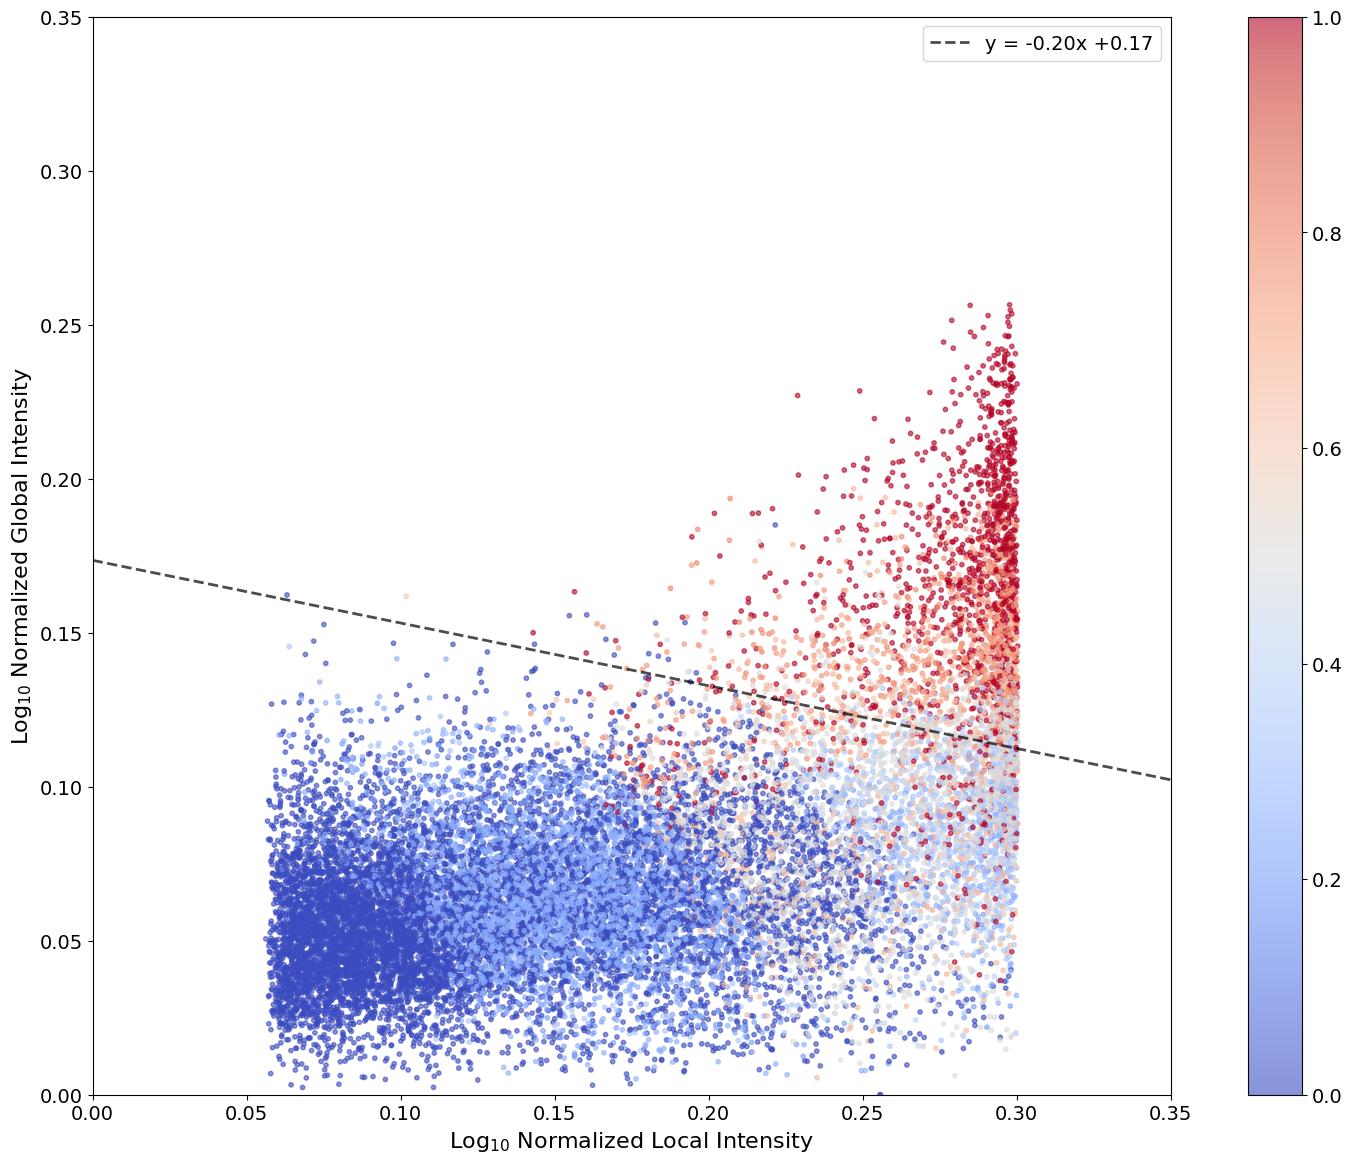

Sample end: 2024-05-20 13:33:19.373151
Duration: 0:03:18.597090


In [7]:
# NeuNのnoise clusterに関して

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import cm

import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from concurrent.futures import ProcessPoolExecutor
from rpy2.rinterface_lib.embedded import RRuntimeError
pandas2ri.activate()

# Rのライブラリをロード
r = robjects.r
r('library(pdfCluster)')

# pdfCluster関数を実行するためのラッパー関数
def run_pdfCluster_multiple_parameter(chunk_df, hmult, ngrid):
    try:
        
        # R環境にデータフレームを渡す
        ro.globalenv['chunk_df'] = pandas2ri.py2rpy(chunk_df)
        # pdfClusterを実行
        r_code = '''
        library(pdfCluster)
        result <- pdfCluster(chunk_df, hmult = {hmult}, n.grid = {ngrid})
        cluster_assignments <- groups(result)
        '''.format(hmult=hmult, ngrid=ngrid)
        ro.r(r_code)
        # クラスタ割り当てを取得
        # resultのクラスをチェック（デバッグ用）
        #print(ro.r('class(result)'))
        cluster_assignments = ro.r('cluster_assignments')
        print("Chunksize: " + str (len(chunk_df)) + ", hmult: " + str(hmult) + ", Ngrid: "+ str(ngrid) + " has done." )
    except RRuntimeError:
        # エラーが発生した場合、チャンク内の全データポイントをクラスタID 0 に割り当てる
        print("Error in processing chunk; assigning cluster ID 0 to all points in the chunk.")
        cluster_assignments = np.zeros(len(chunk_df), dtype=int)
        
    return np.array(cluster_assignments)
dt_simple = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('intensity2_logs','f4'),('intensity3_logs','f4'), 
    ('norm_intensity_2_logs','f4'),('norm_intensity_3_logs','f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2')
])

dt_simple_shuffled = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('intensity2_logs','f4'),('intensity3_logs','f4'), 
    ('norm_intensity_2_logs','f4'),('norm_intensity_3_logs','f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2'),
    ('indices', 'int')
])

dt_threshold = np.dtype([
    ('slope_NeuN', 'f4'), ('intercept_NeuN', 'f4'),
    ('slope_Iba1', 'f4'), ('intercept_Iba1', 'f4'),
    ('best_NeuN_threshold', 'f4'), ('best_Iba1_threshold', 'f4') # 追加した。
])

dt_mask = np.dtype([
    ('mask', 'f4')
])

Sample_num_default = 100000 #50000
chunksize_default = 5000 #5000
hmult_default = 0.70
ngrid_default = 500
plot_num = 20000
ratio = 1#3

NeuN_cluster_threshold_list = [0.80] # だいたいが0.75のはず
NeuN_cluster_noise_threshold_list = [0.55] # だいたいが0.75のはず
Iba1_cluster_threshold_list = [0.55] # だいたいが0.45のはず
Threshold_list = [0.10,0.15, 0.20, 0.25, 0.30,0.35, 0.40,0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]

#for i in range(0, len(Samples)):
#    ngrid_ratio_list.extend(temp_ngrid_ratio_list)

start_time = datetime.datetime.now()
print("start:", start_time)
cmap = cm.get_cmap('RdBu')
cou = 0
for Sample in Samples:
    
    try:
        param_path = "/home/mitani/CUBIC-informatics/param/" + Sample + "/param_multichannel-rank.json"
        print(param_path)
        with open(param_path) as f:
            param = json.load(f)

        fw_dir_nu = param["dst_basedir"]

        data_shuffled = []
        #data_shuffled = np.fromfile(fw_dir_nu + "/For_PDF_clustering_base_data_base_shuffled_Samplesize_" + str(Sample_num_default) +".bin", dtype=dt_simple_shuffled)
        data = []
        data = np.fromfile(fw_dir_nu + "/For_PDF_clustering_base_data_2.bin", dtype=dt_simple)

        end_time = datetime.datetime.now()
        print("Read end:", end_time)
        print("Duration:", end_time - start_time)

        print("#####################  NeuN  ##########################")

        # artifact noiseの影響を受けていそうな点群を決める。

        # 座標のスケーリング
        scaled_x = np.floor(data['mapped_x'] / 50).astype(int)
        scaled_y = np.floor(data['mapped_y'] / 50).astype(int)
        scaled_z = np.floor(data['mapped_z'] / 50).astype(int)

        # 3D画像のサイズ
        depth, height, width = 243, 440, 339
        image_size = depth * height * width

        # インデックスが画像の範囲内に収まるように制限
        scaled_x = np.clip(scaled_x, 0, width - 1)
        scaled_y = np.clip(scaled_y, 0, height - 1)
        scaled_z = np.clip(scaled_z, 0, depth - 1)

        # ボクセルのインデックスを1D配列として計算
        voxel_indices = scaled_z * (height * width) + scaled_y * width + scaled_x
        # ボクセルのインデックスをユニークな値とその出現回数で集約
        unique_indices, counts = np.unique(voxel_indices, return_counts=True)

        end_time = datetime.datetime.now()
        print("end1:", end_time)
        print("Duration:", end_time - start_time)

        # 初期化
        intensity_min = np.full(image_size, np.inf)
        intensity_max = np.full(image_size, -np.inf)
        intensity_sum = np.zeros(image_size)

        # ベクトル化された操作でmin, max, sumを計算
        # logを戻す。
        # norm_intensity_2_restored = data['norm_intensity_2_logs'] #10**data2['norm_intensity_2_logs'] - 1.0
        np.minimum.at(intensity_min, voxel_indices, data['norm_intensity_2_logs'])#data2['norm_intensity_2_logs'])
        np.maximum.at(intensity_max, voxel_indices, data['norm_intensity_2_logs'])#data2['norm_intensity_2_logs'])
        np.add.at(intensity_sum, voxel_indices, data['norm_intensity_2_logs']) #data2['norm_intensity_2_logs'])

        end_time = datetime.datetime.now()
        print("end2:", end_time)
        print("Duration:", end_time - start_time)

        # 平均値の計算
        intensity_mean = np.zeros(image_size)
        non_zero = counts > 0  # ゼロ除算を避ける
        intensity_mean[unique_indices[non_zero]] = intensity_sum[unique_indices[non_zero]] / counts[non_zero]

        end_time = datetime.datetime.now()
        print("end3:", end_time)
        print("Duration:", end_time - start_time)

        # 3D配列に再形成
        intensity_min = intensity_min.reshape((depth, height, width))
        intensity_max = intensity_max.reshape((depth, height, width))
        intensity_mean = intensity_mean.reshape((depth, height, width))

        # 最小値、最大値、平均値が-inf, +infになっている部分を適切な値に置き換え
        intensity_min[intensity_min == np.inf] = 0  # or np.nan, depending on your requirements
        intensity_max[intensity_max == -np.inf] = 0  # or np.nan

        end_time = datetime.datetime.now()
        print("end4:", end_time)
        print("Duration:", end_time - start_time)

        tifffile.imwrite(fw_dir_nu +  "/test_NeuN_norm_intensity_min.tif", intensity_min.astype('float32'))
        tifffile.imwrite(fw_dir_nu +  "/test_NeuN_norm_intensity_max.tif", intensity_max.astype('float32'))
        tifffile.imwrite(fw_dir_nu +  "/test_NeuN_norm_intensity_mean.tif", intensity_mean.astype('float32'))

        from scipy.ndimage import gaussian_filter

        # intensity_meanにガウシアンフィルタを適用
        intensity_mean_filtered1 = gaussian_filter(intensity_mean, sigma=1.0)
        intensity_mean_filtered2 = gaussian_filter(intensity_mean, sigma=2.0)

        intensity_mean_diff = np.where(
            intensity_mean_filtered1 == 0,
            0,
            intensity_mean_filtered2 / intensity_mean_filtered1
        )

        tifffile.imwrite(fw_dir_nu +  "/test_NeuN_norm_intensity_mean_gaus_ratio.tif", intensity_mean_diff.astype('float32'))

        intensity_mean_diff_mask = intensity_mean_diff
        intensity_mean_diff_mask[intensity_mean_diff < 1.10] = 0.0
        intensity_mean_diff_mask[intensity_mean_diff >= 1.10] = 1.0 
        tifffile.imwrite(fw_dir_nu +  "/test_NeuN_norm_intensity_mean_gaus_ratio_mask.tif", intensity_mean_diff_mask.astype('float32'))

        # intensity_mean_diff_maskが1のボクセルのインデックスを1D配列として取得
        mask_indices = np.where(intensity_mean_diff_mask.flatten() == 1)[0]

        extract_index = np.isin(voxel_indices, mask_indices)

        extract_index_to_save = np.zeros((len(data),), dtype=dt_mask)
        extract_index_to_save["mask"] = extract_index
        extract_index_to_save.tofile(fw_dir_nu + "/For_PDF_clustering_base_data_noise_mask_2.bin")

        # data2から条件に一致する要素を抽出
        # 抽出される要素は、intensity_mean_diff_maskが1のボクセルに対応するもの
        extracted_elements = data[extract_index]



        #print("#####################  NeuN  ##########################")

        chunks = []
        data_shuffled_df = []

        #if len(extracted_elements) > Sample_num_default:

        indices = []
        shuffled_indices = []
        indices = np.arange(len(extracted_elements))
        shuffled_indices = np.random.permutation(indices)

        data_shuffled = []
        data_shuffled = np.zeros((len(indices),), dtype=dt_simple_shuffled)
        data_shuffled ['mapped_x'] =extracted_elements['mapped_x'][shuffled_indices]
        data_shuffled ['mapped_y'] = extracted_elements['mapped_y'][shuffled_indices]
        data_shuffled ['mapped_z'] = extracted_elements['mapped_z'][shuffled_indices]
        data_shuffled ['intensity2_logs'] = extracted_elements['intensity2_logs'][shuffled_indices]
        #data_shuffled ['intensity3_logs'] = extracted_elements['intensity3_logs'][shuffled_indices]

        data_shuffled ['norm_intensity_2_logs'] = extracted_elements['norm_intensity_2_logs'][shuffled_indices]
        #data_shuffled ['norm_intensity_3_logs'] = extracted_elements['norm_intensity_3_logs'][shuffled_indices]

        data_shuffled ['NeuN_positive'] = extracted_elements['NeuN_positive'][shuffled_indices]
        #data_shuffled ['Iba1_positive'] = extracted_elements['Iba1_positive'][shuffled_indices]
        data_shuffled ['indices'] = shuffled_indices
        data_shuffled ['atlas_id'] = extracted_elements['atlas_id'][shuffled_indices]

        # data_shuffledの長さとSample_num_defaultのうち、小さい方の値を選択
        num_samples_to_select = min(len(data_shuffled), Sample_num_default)

        data_shuffled_df = pd.DataFrame(data_shuffled[:num_samples_to_select], columns=['intensity2_logs', 'norm_intensity_2_logs'])

        print(len(data_shuffled_df))  

        # ここで ratioを決める。
        # 各列における下位5%と上位5%の値を計算
        percentiles = {}
        for column in data_shuffled_df.columns:
            lower_percentile = data_shuffled_df[column].quantile(0.4)
            upper_percentile = data_shuffled_df[column].quantile(0.6)
            percentiles[column] = {"lower_5%": lower_percentile, "upper_5%": upper_percentile}

        ratio = 1#(percentiles['intensity2_logs']["upper_5%"] -  percentiles['intensity2_logs']["lower_5%"]) / (percentiles['norm_intensity_2_logs']["upper_5%"] -  percentiles['norm_intensity_2_logs']["lower_5%"])
        print("NeuN ratio is: "+  str(ratio))

        #for ii in range(0, len(ngrid_list)):
        chunks.append([data_shuffled_df.iloc[i:i + chunksize_default] for i in range(0, data_shuffled_df.shape[0], chunksize_default)])

        # 並列実行
        cluster_results = []
        temp_chunk = []
        with ProcessPoolExecutor() as executor:
            futures = []
            for chunk in chunks:
                for temp_chunk in chunk:
                    future = executor.submit(run_pdfCluster_multiple_parameter, temp_chunk, hmult_default, ngrid_default)
                    futures.append(future)
            for future in futures:
                cluster_results.append(future.result())

        end_time = datetime.datetime.now()
        print("PDFcluster end:", end_time)
        print("Duration:", end_time - start_time)

        # 直線をSVMで決める
        # plotを書いてvisualizeし、保存
        # 直線の方程式を保存。slopeと切片を保存すればOK
        # あとでまとめて、accuracyなどにする

        cou2=0
        for chunk in chunks:
            # SVM
            X = []  # 特徴量のリスト
            #y = []  # ラベルのリスト
            y0 = [[] for _ in range(len(Threshold_list))] # ラベルのリスト
            z = []
            for chunk_index, temp_chunk in enumerate(chunk):
                cluster_assignments = cluster_results[chunk_index + cou2]
                unique_clusters = np.unique(cluster_assignments)

                # unique_clustersが1つだけの場合、何も追加せずに次のチャンクへ
                if len(unique_clusters) == 1:
                    continue  # このチャンクの処理をスキップ

                cluster_avg_values = []

                # 各クラスタのaverage_valueを計算します。
                for cluster_id in unique_clusters:
                    mask = cluster_assignments == cluster_id
                    selected_indices = np.where(mask)[0]

                    # Dimension 1 + Dimension 2 の平均値を計算
                    average_value = (temp_chunk.iloc[selected_indices, 0]*ratio + temp_chunk.iloc[selected_indices, 1]).mean()
                    cluster_avg_values.append((cluster_id, average_value))

                # 最大のaverage_valueを持つクラスタを取得します。
                max_cluster_id, _ = max(cluster_avg_values, key=lambda item: item[1])
                cluster_avg_values.sort(key=lambda x: x[1], reverse=True)

                # このクラスタをpositiveとして、それ以外をnegativeとして分類します。
                for index, (local_index, row) in zip(cluster_assignments, temp_chunk.iterrows()):
                    X.append(row.values)
                    cluster_index = next((i for i, (cluster_id, _) in enumerate(cluster_avg_values) if cluster_id == index), None)
                    #y.append(1 if np.where(cluster_avg_values == index)[0] / max_cluster_id > 0.99 else 0)
                    normalized_index = cluster_index / (len(cluster_avg_values)-1)

                    z.append(1.0 - normalized_index)
                    for t in range(len(Threshold_list)):
                        y0[t].append(1 if 1.0 - normalized_index > Threshold_list[t] else 0)
                    #y.append(1 if 1.0 - normalized_index > NeuN_cluster_noise_threshold_list[0] else 0)
                    #y.append(1 if index == max_cluster_id else 0)
                    #z.append(1 if index / max_cluster_id > 0.50 else 0)

            print(len(chunk))
            cou2 += len(chunk)
            print(np.unique(z))

            print(NeuN_cluster_noise_threshold_list[0])

            # 特徴量とラベルをNumPy配列に変換します。
            X = np.array(X)
            X_scaled = X #scaler.fit_transform(X)

            target_index = Threshold_list.index(NeuN_cluster_noise_threshold_list[0])

            for t in range(target_index, len(Threshold_list)):
                #y = np.array(y)
                y01 = np.array(y0[t])
                y = y01
                # データを標準化します。
                #scaler = StandardScaler()


                # データをトレーニングセットとテストセットに分割します。
                X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)#test_size=0.2, random_state=42)

                ## 一時的
                y = np.array(z)


                # SVMモデルを作成し、トレーニングセットで学習します。
                model = svm.SVC(kernel='linear')
                model.fit(X_train, y_train)

                # テストセットでモデルを評価します。
                y_pred = model.predict(X_test)

                # 分離直線の係数を取得します。
                w = model.coef_[0]
                slope = -w[0] / w[1]
                intercept = -model.intercept_[0] / w[1]

                thresold = np.zeros((1,), dtype=dt_threshold)
                thresold['slope_NeuN'] = slope
                thresold['intercept_NeuN'] = intercept

                #thresold.tofile(fw_dir_nu + "/PDFcluster_NeuN_thresold_extract_"+ str(NeuN_cluster_noise_threshold_list[0]) + ".bin")
                slope = thresold["slope_NeuN"][0]
                intercept = thresold['intercept_NeuN'][0]

                if thresold["slope_NeuN"] < 0: 
                    auto_classified_NeuN = thresold["slope_NeuN"]*(-1) *  X[:, 0] + 1.0 * X[:, 1] + thresold["intercept_NeuN"]*(-1) > 0
                if thresold["slope_NeuN"] >= 0: 
                    auto_classified_NeuN = thresold["slope_NeuN"]*(-1) *  X[:, 0] + 1.0 * X[:, 1] + thresold["intercept_NeuN"]*(-1) < 0

                print("Total cell number: " + str(len(X))) 
                print("NeuN threshold: " + str(Threshold_list[t]))
                print("Total NeuN+ cell number: " + str(np.sum(auto_classified_NeuN)))
                print("NeuN+ %: " + str((np.sum(auto_classified_NeuN)/len(X))*100) + " %")

                if np.sum(auto_classified_NeuN)/len(X) > 0.0:
                    print("Determined NeuN threshold is: " + str(Threshold_list[t]))
                    thresold ['best_NeuN_threshold'] = Threshold_list[t]
                    thresold.tofile(fw_dir_nu + "/PDFcluster_NeuN_thresold_extract_"+ str(NeuN_cluster_noise_threshold_list[0]) + ".bin")

                    # グラフの余白を調整
                    #plt.subplots_adjust(right=0.75)

                    # 分離直線をプロットします。
                    xx = np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max())
                    yy = slope * xx + intercept

                    end_time = datetime.datetime.now()
                    print("end:", end_time)
                    print("Duration:", end_time - start_time)

                    plt.figure(figsize=(20, 14))
                    plt.rcParams['font.family'] = 'Arial'
                    plt.rcParams['font.size'] = 14  # Adjust the size as needed


                    total_elements = len(X)
                    temp_plot_num = plot_num
                    if plot_num > total_elements:
                        temp_plot_num = total_elements
                    indices = np.linspace(0, total_elements - 1, temp_plot_num, dtype=int) 
                    print(len(indices))
                    # グラフにプロット
                    plt.scatter(X_scaled[:, 0][indices], X_scaled[:, 1][indices], c=y[indices], cmap=cm.get_cmap('coolwarm'), alpha=0.6, s=5+5)
                    plt.colorbar()

                    x_vals = np.linspace(0.0, 0.35, 100)
                    y_vals = slope * x_vals + intercept


                    # interceptが負の場合は、符号を自動的に表示しますが、正の場合は明示的に'+'を表示します。
                    label = f'y = {slope:.2f}x {"+" if intercept >= 0 else "-"}{abs(intercept):.2f}'

                    # y = ax + b の直線をプロット
                    plt.plot(x_vals, y_vals, color='black', linestyle='--',linewidth=2, alpha = 0.7, label=label)      


                    # グラフの表示範囲を設定
                    plt.xlim(0.0, 0.35)
                    plt.ylim(0.0, 0.35)

                    # アスペクト比を等しく設定
                    #plt.gca().set_aspect('equal', adjustable='box')
                    plt.gca().set_aspect('equal', adjustable='box')

                    # タイトルと軸ラベルを設定
                    #plt.title('SVM Classifier for the Highest Average Value Cluster in Each Chunk')
                    plt.xlabel('Log$_{10}$ Normalized Local Intensity', fontsize=16)
                    plt.ylabel('Log$_{10}$ Normalized Global Intensity', fontsize=16)
                    plt.legend(fontsize=14)

                    plt.savefig(fw_dir_nu + "/PDFcluster_NeuN_plot_extract_" +str(NeuN_cluster_noise_threshold_list[0])+ ".png", transparent=True,  dpi=300,)
                    # グラフを表示
                    plt.show()
                    break
        del data_shuffled, data_shuffled_df, futures, chunks, cluster_results, data
        gc.collect() 

        cou += 1

        end_time = datetime.datetime.now()
        print("Sample end:", end_time)
        print("Duration:", end_time - start_time)
    except Exception as e:
        print(f"Error loading data for {Sample}: {e}")

In [10]:
# NeuN noise clusterにも対応させた。

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import cm

import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from concurrent.futures import ProcessPoolExecutor
from rpy2.rinterface_lib.embedded import RRuntimeError
pandas2ri.activate()

# Rのライブラリをロード
r = robjects.r
r('library(pdfCluster)')


dt_simple_shuffled = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('intensity2_logs','f4'),('intensity3_logs','f4'), 
    ('norm_intensity_2_logs','f4'),('norm_intensity_3_logs','f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2'),
    ('indices', 'int')
])

dt_simple = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('intensity2_logs','f4'),('intensity3_logs','f4'), 
    ('norm_intensity_2_logs','f4'),('norm_intensity_3_logs','f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2')
])

dt_simple2 = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2')
])

dt_threshold = np.dtype([
    ('slope_NeuN', 'f4'), ('intercept_NeuN', 'f4'),
    ('slope_Iba1', 'f4'), ('intercept_Iba1', 'f4'),
    ('best_NeuN_threshold', 'f4'), ('best_Iba1_threshold', 'f4') # 追加した。
])

dt_mask = np.dtype([
    ('mask', 'f4')
])

NeuN_only_mode = 0 #1 # 1はNeuN only, 0はboth、-1はIba1 only

Sample_num_default = 100000 
chunksize_default = 5000 
hmult_default = 0.70
ngrid_default = 500
plot_num = 20000
ratio = 1

NeuN_cluster_threshold_list = [0.80] # だいたいが0.75のはず
NeuN_cluster_noise_threshold_list = [0.55] # だいたいが0.75のはず
Iba1_cluster_threshold_list = [0.55] # だいたいが0.45のはず
Threshold_list = [0.10,0.15, 0.20, 0.25, 0.30,0.35, 0.40,0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]

start_time = datetime.datetime.now()
print("start:", start_time)

cou = 0
for Sample in Samples:
    
    try:
        param_path = "/home/mitani/CUBIC-informatics/param/" + Sample + "/param_multichannel-rank.json"
        print(param_path)
        with open(param_path) as f:
            param = json.load(f)

        fw_dir_nu = param["dst_basedir"]

        data = []
        data = np.fromfile(fw_dir_nu + "/For_PDF_clustering_base_data_2.bin", dtype=dt_simple)

        end_time = datetime.datetime.now()
        print("Read end:", end_time)
        print("Duration:", end_time - start_time)

        # 初期化
        auto_classified_NeuN =  data["intensity2_logs"] < 0
        auto_classified_Iba1 =  data["intensity3_logs"] < 0

        if NeuN_only_mode >= 0:
            print("#####################  NeuN  ##########################")   


            thresold = np.fromfile(fw_dir_nu + "/PDFcluster_NeuN_thresold_"+ str(NeuN_cluster_threshold_list[0]) + ".bin", dtype=dt_threshold)

            print(thresold)
            #### 直線を修正
            #### (0.0, thresold["intercept_NeuN"]) と (0.0, 0.30)を通る直線に修正。
            #x1, y1 = 0.175, thresold["slope_NeuN"] * 0.175 + thresold["intercept_NeuN"]
            #x2, y2 = 0.30, 0.0

            #thresold["slope_NeuN"] = (y2 - y1) / (x2 - x1)
            #thresold["intercept_NeuN"] = y1 - thresold["slope_NeuN"] * x1
            #print(thresold) 

            if thresold["slope_NeuN"] < 0: 
                auto_classified_NeuN = thresold["slope_NeuN"]*(-1) *  data["intensity2_logs"] + 1.0 * data["norm_intensity_2_logs"] + thresold["intercept_NeuN"]*(-1) > 0
            if thresold["slope_NeuN"] >= 0:
                auto_classified_NeuN = thresold["slope_NeuN"]*(-1) *  data["intensity2_logs"] + 1.0 * data["norm_intensity_2_logs"] + thresold["intercept_NeuN"]*(-1) < 0

            #auto_classified_NeuN[(-3.0)*(-1) *  data["intensity2_logs"] + 1.0 * data["norm_intensity_2_logs"] + 0.9*(-1) > 0] = 1

            thresold_noise = np.fromfile(fw_dir_nu + "/PDFcluster_NeuN_thresold_extract_"+ str(NeuN_cluster_noise_threshold_list[0]) + ".bin", dtype=dt_threshold)

            print(thresold_noise)

            #### 直線を修正
            #### (0.0, thresold["intercept_NeuN"]) と (0.0, 0.30)を通る直線に修正。
            x1, y1 = 0.22, thresold_noise["slope_NeuN"] * 0.22 + thresold_noise["intercept_NeuN"]
            x2, y2 = 0.27, 0.0

            thresold_noise["slope_NeuN"] = (y2 - y1) / (x2 - x1)
            thresold_noise["intercept_NeuN"] = y1 - thresold_noise["slope_NeuN"] * x1
            print(thresold_noise) 

            extract_mask  = np.fromfile(fw_dir_nu + "/For_PDF_clustering_base_data_noise_mask_2.bin", dtype=dt_mask)
            extract_mask = extract_mask['mask'] > 0

            if thresold["slope_NeuN"] < 0: 
                auto_classified_NeuN[extract_mask] = thresold_noise["slope_NeuN"]*(-1) *  data["intensity2_logs"][extract_mask] + 1.0 * data["norm_intensity_2_logs"][extract_mask] + thresold_noise["intercept_NeuN"]*(-1) > 0
            if thresold["slope_NeuN"] >= 0:
                auto_classified_NeuN[extract_mask] = thresold_noise["slope_NeuN"]*(-1) *  data["intensity2_logs"][extract_mask] + 1.0 * data["norm_intensity_2_logs"][extract_mask] + thresold_noise["intercept_NeuN"]*(-1) < 0


            auto_classified_Iba1 = auto_classified_NeuN


        if NeuN_only_mode <= 0:

            try:
                print("#####################  Iba1  ##########################")

                thresold = np.fromfile(fw_dir_nu + "/PDFcluster_Iba1_thresold_"+ str(Iba1_cluster_threshold_list[0]) + ".bin", dtype=dt_threshold)
                print(thresold)
                #### 直線を修正
                #### (0.0, thresold["intercept_NeuN"]) と (0.0, 0.30)を通る直線に修正。
                x1, y1 = 0.27, thresold["slope_Iba1"] * 0.27 + thresold["intercept_Iba1"]
                x2, y2 = 0.35, 0.0

                thresold["slope_Iba1"] = (y2 - y1) / (x2 - x1)
                thresold["intercept_Iba1"] = y1 - thresold["slope_Iba1"] * x1
                print(thresold)

                if thresold["slope_Iba1"] < 0: 
                    auto_classified_Iba1 = thresold["slope_Iba1"]*(-1) *  data["intensity3_logs"] + 1.0 * data["norm_intensity_3_logs"] + thresold["intercept_Iba1"]*(-1) > 0
                if thresold["slope_Iba1"] >= 0: 
                    auto_classified_Iba1 = thresold["slope_Iba1"]*(-1) *  data["intensity3_logs"] + 1.0 * data["norm_intensity_3_logs"] + thresold["intercept_Iba1"]*(-1) < 0

            except:
                print("Iba1 data does not exist.")


        data2 = np.zeros((len(data),), dtype=dt_simple2)

        data2['mapped_x'] = data['mapped_x']
        data2['mapped_y'] = data['mapped_y']
        data2['mapped_z'] = data['mapped_z']
        if NeuN_only_mode >= 0:
            data2['NeuN_positive'] = auto_classified_NeuN
        data2['Iba1_positive'] = auto_classified_Iba1
        data2['atlas_id'] = data['atlas_id']

        if 1==1:
            data2.tofile(fw_dir_nu + "/For_PDF_clustering_base_data_classified_NeuN_" + str(NeuN_cluster_threshold_list[0]) +
                         "_noise_"+str(NeuN_cluster_noise_threshold_list[0]) +
                         "_Iba1_" +str(Iba1_cluster_threshold_list[0])  +"_2.bin")
        scale = 1/50

        depth_ori =  243 
        height_ori = 440 
        width_ori = 339 

        #print(depth_ori)
        #print(height_ori)
        #print(width_ori)

        img_filename_Nuclear_Isocortex_to_ori = fw_dir_nu +  "/PDFcluster_All_Cell_2.tif"

        if 1==1:                                                                                     
            img_N_ori,_ = np.histogramdd(
                np.vstack([
                    data2["mapped_z"] * scale,
                    data2["mapped_y"] * scale,
                    data2["mapped_x"] * scale,
                    ]).T,
                    bins=(depth_ori, height_ori, width_ori),
                    range=[(0,depth_ori),(0,height_ori),(0,width_ori)]
                )

            tifffile.imsave(
                    img_filename_Nuclear_Isocortex_to_ori,
                    img_N_ori.astype(np.float32)
                )

        scale = 1/50

        depth_ori =  243 
        height_ori = 440 
        width_ori = 339 

        #print(depth_ori)
        #print(height_ori)
        #print(width_ori)

        if NeuN_only_mode>=0:

            print("\n")
            print("Total cell number: " + str(len(data2)))
            print("NeuN threshold: " + str(NeuN_cluster_threshold_list[0]))
            print("Total NeuN+ cell number: " + str(np.sum(data2['NeuN_positive'] > 0)))
            print("NeuN %: " + str((np.sum(data2['NeuN_positive'] > 0)/len(data2)) * 100) + " %")
            percentage = np.round((np.sum(data2['NeuN_positive'] > 0)/len(data2)) * 100, 2)
            img_filename_Nuclear_Isocortex_to_ori = (fw_dir_nu +  "/PDFcluster_NeuN_classified_" 
            +str(NeuN_cluster_threshold_list[0]) + "_noise_"+str(NeuN_cluster_noise_threshold_list[0]) 
            +"_"+ str(percentage)+"%_2.tif")

            img_N_ori,_ = np.histogramdd(
                np.vstack([
                    data2["mapped_z"][data2['NeuN_positive'] > 0] * scale,
                    data2["mapped_y"][data2['NeuN_positive'] > 0] * scale,
                    data2["mapped_x"][data2['NeuN_positive'] > 0] * scale,
                    ]).T,
                    bins=(depth_ori, height_ori, width_ori),
                    range=[(0,depth_ori),(0,height_ori),(0,width_ori)]
                )

            tifffile.imsave(
                    img_filename_Nuclear_Isocortex_to_ori,
                    img_N_ori.astype(np.float32)
                )

        if NeuN_only_mode <= 0:

            print("\n")
            print("Total cell number: " + str(len(data2))) 
            print("Iba1 threshold: " + str(Iba1_cluster_threshold_list[0]))
            print("Total Iba1+ cell number: " + str(np.sum(data2['Iba1_positive'] > 0)))
            print("Iba1 %: " + str((np.sum(data2['Iba1_positive'] > 0)/len(data2))*100) + " %")
            percentage = np.round((np.sum(data2['Iba1_positive'] > 0)/len(data2)) * 100, 2)
            img_filename_Nuclear_Isocortex_to_ori = (fw_dir_nu + "/PDFcluster_Iba1_classified_land_"
            + str(Iba1_cluster_threshold_list[0])
            + "_" + str(percentage) + "%_2.tif")
            img_N_ori,_ = np.histogramdd(
                np.vstack([
                    data2["mapped_z"][data2['Iba1_positive'] > 0] * scale,
                    data2["mapped_y"][data2['Iba1_positive'] > 0] * scale,
                    data2["mapped_x"][data2['Iba1_positive'] > 0] * scale,
                    ]).T,
                    bins=(depth_ori, height_ori, width_ori),
                    range=[(0,depth_ori),(0,height_ori),(0,width_ori)]
                )

            tifffile.imsave(
                    img_filename_Nuclear_Isocortex_to_ori,
                    img_N_ori.astype(np.float32)
                )


        cou += 1
    except Exception as e:
        print(f"Error loading data for {Sample}: {e}")

print("\n")      
end_time = datetime.datetime.now()
print("All End:", end_time)
print("Duration:", end_time - start_time)



start: 2024-05-20 13:33:19.413888
/home/mitani/CUBIC-informatics/param/Neuronomics/#4_APPmodel_APP5m_2_2022_1027_1333/param_multichannel-rank.json
Read end: 2024-05-20 13:33:20.613045
Duration: 0:00:01.199157
#####################  NeuN  ##########################
[(-0.99868864, 0.3482936, 0., 0., 0.8, 0.)]
[(-0.20358618, 0.17350498, 0., 0., 0.55, 0.)]
[(-2.5743203, 0.69506645, 0., 0., 0.55, 0.)]
#####################  Iba1  ##########################
[(0., 0., -0.83528817, 0.37768877, 0., 0.55)]
[(0., 0., -1.902012, 0.6657042, 0., 0.55)]


Total cell number: 99099502
NeuN threshold: 0.8
Total NeuN+ cell number: 55498445
NeuN %: 56.002748631370515 %


Total cell number: 99099502
Iba1 threshold: 0.55
Total Iba1+ cell number: 3275286
Iba1 %: 3.305047890149841 %


All End: 2024-05-20 13:34:07.819175
Duration: 0:00:48.405287
